# Import Packages

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from numpy import where
import pandas as pd

import seaborn as sns

import sklearn
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification

from imblearn.over_sampling import SMOTE

from collections import Counter

from PIL import Image

from random import shuffle

import nltk
from nltk import NaiveBayesClassifier, classify
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag

nltk.download(['stopwords', 'vader_lexicon'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dando\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Read in Data File

In [2]:
df = pd.read_csv("DisneylandReviews.csv", encoding='latin-1')

# Data Exploration & Cleaning

## Data Exploration

In [3]:
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [4]:
df.Branch.unique()

array(['Disneyland_HongKong', 'Disneyland_California', 'Disneyland_Paris'],
      dtype=object)

In [5]:
df.Rating.unique()

array([4, 3, 5, 2, 1], dtype=int64)

The data we are working with includes reviews posted to Tripadvisor and include reviews of 3 different Disneyland resorts.

We have review text along with a score on a scale of 1 to 5, the year and month of the review, reviewer location, and the Disney Resort location. 

All reviews are indexed with a review ID.

In [6]:
df.Review_ID.nunique()

42636

In [7]:
df.shape

(42656, 6)

## Data Cleaning

We examined the dataframe for duplicate review IDs and found there were duplicate reviews that needed to be removed.

In [8]:
df = df.drop_duplicates(subset = ['Review_ID'])

In [9]:
df.shape

(42636, 6)

In [10]:
df.Review_ID.nunique()

42636

Duplicate reviews have been dropped.

To aid in our analysis we want to categorize the numerical ratings into sentiments of positive, neutral, and negative.

In [11]:
def bin_sent(rating):
    if rating in [5,4]:
        return 'positive'
    elif rating in [3]:
        return 'neutral'
    else:
        return 'negative'

In [12]:
df['sentiment'] = df['Rating'].apply(bin_sent)
df

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,sentiment
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,positive
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,positive
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,positive
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,positive
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,positive
...,...,...,...,...,...,...,...
42651,1765031,5,missing,United Kingdom,i went to disneyland paris in july 03 and thou...,Disneyland_Paris,positive
42652,1659553,5,missing,Canada,2 adults and 1 child of 11 visited Disneyland ...,Disneyland_Paris,positive
42653,1645894,5,missing,South Africa,My eleven year old daughter and myself went to...,Disneyland_Paris,positive
42654,1618637,4,missing,United States,"This hotel, part of the Disneyland Paris compl...",Disneyland_Paris,positive


In [13]:
df[df.Branch=="Disneyland_HongKong"]

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,sentiment
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,positive
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,positive
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,positive
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,positive
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,positive
...,...,...,...,...,...,...,...
9615,4033897,1,missing,United States,My husband and I took our 2 kids and it was th...,Disneyland_HongKong,negative
9616,4020946,2,missing,United States,The park is small. Tiny small.They say one of ...,Disneyland_HongKong,negative
9617,3998899,4,missing,United Kingdom,Visited Hong Kong Disneyland on the 28th Septe...,Disneyland_HongKong,positive
9618,3924467,4,missing,Philippines,"Visited Hkg Disney Sept 16 ,5 days after it of...",Disneyland_HongKong,positive


In [14]:
#export to csv 
df.to_csv('DisneylandReviewsWithSent.csv')

# Process Text Data

In [15]:
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['Review_Text']), axis=1)

In [16]:
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,sentiment,tokenized_sents
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,positive,"[If, you, 've, ever, been, to, Disneyland, any..."
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,positive,"[Its, been, a, while, since, d, last, time, we..."
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,positive,"[Thanks, God, it, wasn, t, too, hot, or, too, ..."
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,positive,"[HK, Disneyland, is, a, great, compact, park, ..."
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,positive,"[the, location, is, not, in, the, city, ,, too..."


In [17]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(["disney", "disneyland", "california", "hong kong", "paris", "park", "everything", "go", "day", 
                 "much", "get", "one", "would", "u", "way"])

In [18]:
def updated_list(txt_list):
    newList = []
#    stopwords = nltk.corpus.stopwords.words('english')
    
    for word in txt_list:
        if ((not word.isalpha()) or(word in stopwords)):
            continue      
        newList.append(word.lower())
    return newList

In [19]:
df["cleaned_text"] = df["tokenized_sents"].apply(lambda x: updated_list(x))
#cleaned text with stopwords/non-alpha removed, converted to lower

In [20]:
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,sentiment,tokenized_sents,cleaned_text
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,positive,"[If, you, 've, ever, been, to, Disneyland, any...","[if, ever, disneyland, anywhere, find, disneyl..."
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,positive,"[Its, been, a, while, since, d, last, time, we...","[its, since, last, time, visit, hk, disneyland..."
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,positive,"[Thanks, God, it, wasn, t, too, hot, or, too, ...","[thanks, god, hot, humid, i, visiting, otherwi..."
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,positive,"[HK, Disneyland, is, a, great, compact, park, ...","[hk, disneyland, great, compact, unfortunately..."
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,positive,"[the, location, is, not, in, the, city, ,, too...","[location, city, took, around, hour, kowlon, k..."


# Words per Review

In [21]:
#generate word count per review
word_count = []
for row in df.cleaned_text.index:
    word_count.append(len([i for i in df.cleaned_text[row]]))

In [22]:
df["word_count"] = word_count
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,sentiment,tokenized_sents,cleaned_text,word_count
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,positive,"[If, you, 've, ever, been, to, Disneyland, any...","[if, ever, disneyland, anywhere, find, disneyl...",33
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,positive,"[Its, been, a, while, since, d, last, time, we...","[its, since, last, time, visit, hk, disneyland...",117
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,positive,"[Thanks, God, it, wasn, t, too, hot, or, too, ...","[thanks, god, hot, humid, i, visiting, otherwi...",78
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,positive,"[HK, Disneyland, is, a, great, compact, park, ...","[hk, disneyland, great, compact, unfortunately...",46
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,positive,"[the, location, is, not, in, the, city, ,, too...","[location, city, took, around, hour, kowlon, k...",14


In [23]:
#max word counts for reviews, broken up by sentiment
df.groupby("sentiment").word_count.max()

sentiment
negative    1330
neutral     1035
positive    1897
Name: word_count, dtype: int64

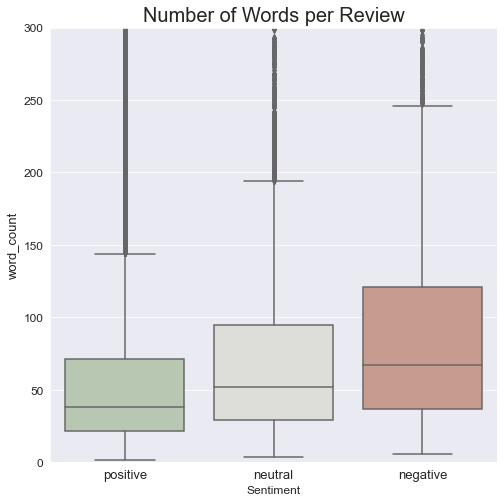

In [24]:
#plotting words per review
palette1 =['#B6CBAE','#DEDDD8','#D19686']
plt.figure(figsize=(8,8))
sns.set({'axes.facecolor':'white'},style="darkgrid",font_scale=2)
ax = sns.boxplot(y=df['word_count'],x=df['sentiment'], palette = palette1)
plt.ylim(0, 300)
plt.title('Number of Words per Review',size=20)
plt.xlabel('Sentiment', size=12)
plt.ylabel('word_count', size=13)
plt.xticks(size=13)
plt.yticks(size=12)
plt.show()

# Word Clouds

In [25]:
from wordcloud import WordCloud

In [26]:
#join clean text rows together to generate word clouds

In [27]:
df_full_wordcloud = ""
for i,row in df.iterrows():
    df_full_wordcloud+=" ".join(row["cleaned_text"])
    

In [28]:
df_HongKong_wordcloud = ""
for i,row in df[df.Branch=="Disneyland_HongKong"].iterrows():
    df_HongKong_wordcloud+=" ".join(row["cleaned_text"])

In [29]:
df_California_wordcloud = ""
for i,row in df[df.Branch=="Disneyland_California"].iterrows():
    df_California_wordcloud+=" ".join(row["cleaned_text"])

In [30]:
df_Paris_wordcloud = ""
for i,row in df[df.Branch=="Disneyland_Paris"].iterrows():
    df_Paris_wordcloud+=" ".join(row["cleaned_text"])

In [31]:
df_positive_wordcloud = ""
for i,row in df[df.sentiment=="positive"].iterrows():
    df_positive_wordcloud+=" ".join(row["cleaned_text"])

In [32]:
df_negative_wordcloud = ""
for i,row in df[df.sentiment=="negative"].iterrows():
    df_negative_wordcloud+=" ".join(row["cleaned_text"])

### Generate Word Clouds

In [33]:
disneyland_mask2 = np.array(Image.open(R'Mickey Mouse.jfif'))

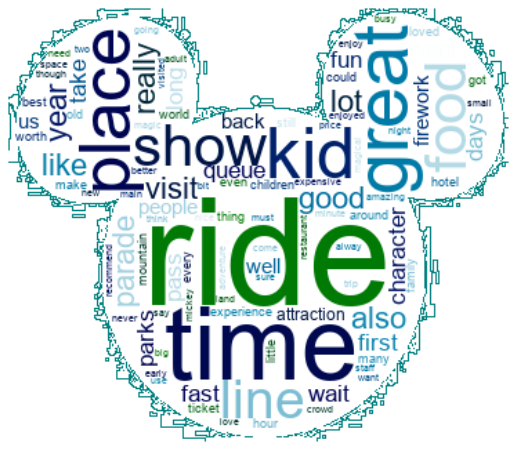

In [37]:
# positive mask
word_cloud_pos = WordCloud(collocations = False, stopwords=stopwords,mask=disneyland_mask2,contour_width=0.1, max_words=100, 
                           background_color = 'white', colormap='ocean', contour_color='teal', 
                           font_path = 'arial').generate(df_positive_wordcloud)
plt.figure(figsize=[9,12])
plt.imshow(word_cloud_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

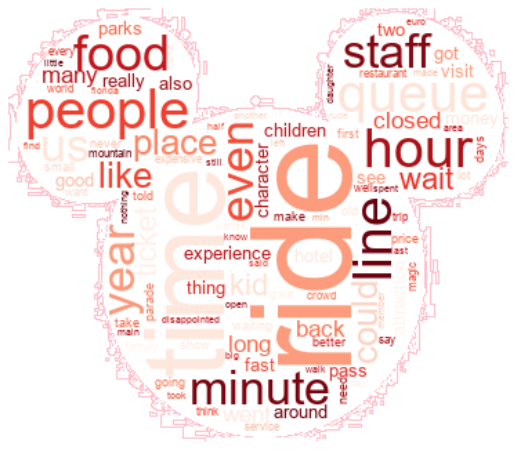

In [38]:
#negative mask
word_cloud_neg = WordCloud(collocations = False, stopwords=stopwords, max_words=100, mask=disneyland_mask2, contour_width=0.1,
                           background_color = 'white', colormap='Reds', contour_color='pink',
                           font_path = 'arial').generate(df_negative_wordcloud)
plt.figure(figsize=[9,12])
plt.imshow(word_cloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

# Sentiment Analysis

### Create Test and Training Sets

In [58]:
#extract dependent and independent variables from dataframe
X = df[['Review_Text']].copy()
y = df[['sentiment']].copy()

In [59]:
#create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                            test_size = 0.4,
                                            random_state = 111)


### Vectorize

In building our models, we have experimented with both bag-of-words and TFIDF vectorizers.

In [60]:
#bag-of-words
vectorizer1 = CountVectorizer(token_pattern=r'\b\w+\b')

X_train_bow = vectorizer1.fit_transform(X_train['Review_Text'])
X_test_bow = vectorizer1.transform(X_test['Review_Text'])

In [61]:
#tfidf
vectorizer2 = TfidfVectorizer(lowercase=True, stop_words='english', min_df=2,ngram_range=(1,4))

X_train_tfidf = vectorizer2.fit_transform(X_train['Review_Text'])
X_test_tfidf = vectorizer2.transform(X_test['Review_Text'])

## Models

### Logistic Regression

In [62]:
lr = LogisticRegression(multi_class = 'multinomial', C = 5, solver = 'lbfgs')

In [63]:
#lr.fit(X_train_bow, y_train)
lr.fit(X_train_tfidf, y_train)

C:\Users\dando\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\dando\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=5, multi_class='multinomial')

In [64]:
#lr_predictions = lr.predict(X_test_bow)
lr_predictions = lr.predict(X_test_tfidf)

In [65]:
lr_cf_matrix = confusion_matrix(y_test, lr_predictions)

<AxesSubplot:>

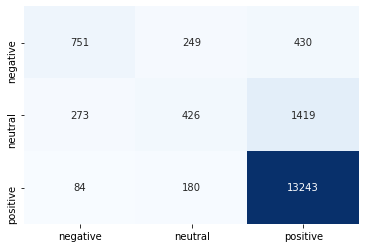

In [87]:
x_axis_labels = ['negative', 'neutral','positive'] # labels for x-axis
y_axis_labels = ['negative', 'neutral','positive'] # labels for y-axis

sns.heatmap(lr_cf_matrix, fmt = '', annot = True, xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels, cmap = 'Blues', cbar = False)

In [67]:
print(classification_report(lr_predictions,y_test))

              precision    recall  f1-score   support

    negative       0.53      0.68      0.59      1108
     neutral       0.20      0.50      0.29       855
    positive       0.98      0.88      0.93     15092

    accuracy                           0.85     17055
   macro avg       0.57      0.68      0.60     17055
weighted avg       0.91      0.85      0.87     17055



Result: Model is performing slightly better using tfidf vectorizer than with bag of words vectorizer.

### Support Vector Machine

In [68]:
svm = SVC()

In [69]:
#svm.fit(X_train_bow, y_train)
svm.fit(X_train_tfidf, y_train)

C:\Users\dando\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC()

In [70]:
#svm_predictions = svm.predict(X_test_bow)
svm_predictions = svm.predict(X_test_tfidf)

In [71]:
svm_cf_matrix = confusion_matrix(y_test, svm_predictions)

<AxesSubplot:>

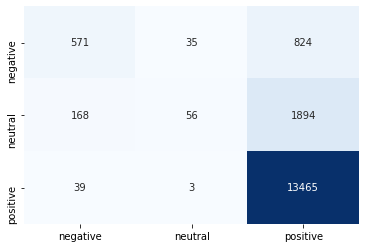

In [86]:
x_axis_labels = ['negative', 'neutral','positive'] # labels for x-axis
y_axis_labels = ['negative', 'neutral','positive'] # labels for y-axis

sns.heatmap(svm_cf_matrix, fmt = '', annot = True, xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels, cmap = 'Blues', cbar = False)

In [73]:
print(classification_report(svm_predictions,y_test))

              precision    recall  f1-score   support

    negative       0.40      0.73      0.52       778
     neutral       0.03      0.60      0.05        94
    positive       1.00      0.83      0.91     16183

    accuracy                           0.83     17055
   macro avg       0.47      0.72      0.49     17055
weighted avg       0.96      0.83      0.88     17055



Result: Bag-of-words vectorizer is not effective for naive bayes.

### Naive Bayes

In [74]:
nb = MultinomialNB()

In [75]:
nb.fit(X_train_bow, y_train)
#nb.fit(X_train_tfidf, y_train)

C:\Users\dando\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()

In [76]:
nb_predictions = nb.predict(X_test_bow)
#nb_predictions = nb.predict(X_test_tfidf)

In [77]:
nb_cf_matrix = confusion_matrix(y_test, nb_predictions)

<AxesSubplot:>

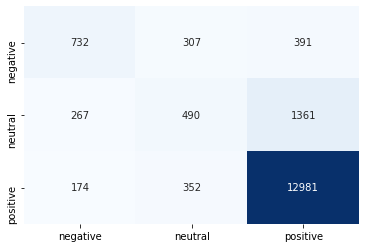

In [85]:
x_axis_labels = ['negative', 'neutral','positive'] # labels for x-axis
y_axis_labels = ['negative', 'neutral','positive'] # labels for y-axis

sns.heatmap(nb_cf_matrix, fmt = '', annot = True, xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels, cmap = 'Blues', cbar = False)

In [79]:
print(classification_report(nb_predictions,y_test))

              precision    recall  f1-score   support

    negative       0.51      0.62      0.56      1173
     neutral       0.23      0.43      0.30      1149
    positive       0.96      0.88      0.92     14733

    accuracy                           0.83     17055
   macro avg       0.57      0.64      0.59     17055
weighted avg       0.88      0.83      0.85     17055



Result: TFIDF vectorizer is not effective for naive bayes.

### Oversampling

In [46]:
sm = SMOTE()
X_res_tfidf, y_res = sm.fit_resample(X_train_tfidf, y_train)
X_res_bow, y_res = sm.fit_resample(X_train_bow, y_train)

### Logistic Regression with Oversampling

In [47]:
lr_o = LogisticRegression(multi_class = 'multinomial', C = 5, solver = 'lbfgs')

In [48]:
lr_o.fit(X_res_tfidf, y_res)

C:\Users\dando\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\dando\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=5, multi_class='multinomial')

In [49]:
lr_over_predictions = lr_o.predict(X_test_tfidf)

In [50]:
lr_over_cf_matrix = confusion_matrix(y_test, lr_over_predictions)

<AxesSubplot:>

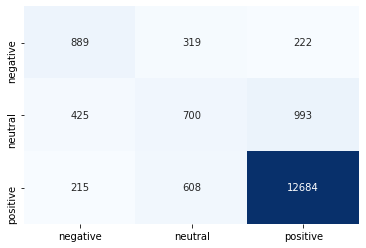

In [90]:
x_axis_labels = ['negative', 'neutral','positive'] # labels for x-axis
y_axis_labels = ['negative', 'neutral','positive'] # labels for y-axis

sns.heatmap(lr_over_cf_matrix, fmt = '', annot = True, xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels, cmap = 'Blues', cbar = False)

In [91]:
print(classification_report(lr_over_predictions,y_test))

              precision    recall  f1-score   support

    negative       0.62      0.58      0.60      1529
     neutral       0.33      0.43      0.37      1627
    positive       0.94      0.91      0.93     13899

    accuracy                           0.84     17055
   macro avg       0.63      0.64      0.63     17055
weighted avg       0.85      0.84      0.84     17055



### Support Vector Machine with Oversampling

In [ ]:
svm_o = SVC()
svm_o.fit(X_res_tfidf, y_res)

C:\Users\dando\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
svm_over_predictions = svm_o.predict(X_test_tfidf)

In [ ]:
svm_over_cf_matrix = confusion_matrix(y_test, svm_over_predictions)

In [ ]:
x_axis_labels = ['negative', 'neutral','positive'] # labels for x-axis
y_axis_labels = ['negative', 'neutral','positive'] # labels for y-axis

sns.heatmap(svm_over_cf_matrix, fmt = '', annot = True, xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels, cmap = 'Blues', cbar = False)

In [ ]:
print(classification_report(svm_over_predictions,y_test))

### Naive Bayes with Oversampling

In [92]:
nb_o = MultinomialNB()
nb_o.fit(X_res_bow, y_res)

C:\Users\dando\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MultinomialNB()

In [93]:
nb_over_predictions = nb_o.predict(X_test_bow)

In [94]:
nb_over_cf_matrix = confusion_matrix(y_test, nb_over_predictions)

<AxesSubplot:>

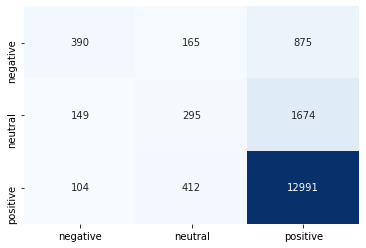

In [95]:
x_axis_labels = ['negative', 'neutral','positive'] # labels for x-axis
y_axis_labels = ['negative', 'neutral','positive'] # labels for y-axis

sns.heatmap(nb_over_cf_matrix, fmt = '', annot = True, xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels, cmap = 'Blues', cbar = False)

In [96]:
print(classification_report(nb_over_predictions,y_test))

              precision    recall  f1-score   support

    negative       0.27      0.61      0.38       643
     neutral       0.14      0.34      0.20       872
    positive       0.96      0.84      0.89     15540

    accuracy                           0.80     17055
   macro avg       0.46      0.59      0.49     17055
weighted avg       0.89      0.80      0.84     17055



## Predict Sentiment

From our analysis above, we have found that logistic regression with oversampling had the best performance.

We have used that model for the below prediction of sentiment.

In [97]:
df_nr = pd.read_csv("test_data.csv", encoding='latin-1')

In [98]:
new_reviews = vectorizer2.transform(df_nr['Review_Text'])

In [99]:
lr_predictions_new = lr_o.predict(new_reviews)

In [100]:
df_nr['predicted_sentiment'] = pd.Series(lr_predictions_new)

In [101]:
df_nr

,ï»¿source,branch,Review_Text,predicted_sentiment
0,Facebook,Disneyland_California,We stayed at the California Grand and it was s...,neutral
1,Facebook,Disneyland_California,"Super crowded, full of rude people who just ru...",negative
2,Facebook,Disneyland_California,"Disney was awesome, better then expected. Geni...",positive
3,Facebook,Disneyland_California,They no longer stand for basic family values. ...,neutral
4,Yelp,Disneyland_California,There's an undeniable magic to Disneyland. I m...,positive
5,Yelp,Disneyland_California,Haven't been to Disneyland for years. It was ...,neutral
6,Tripadvisor,Disneyland_Paris,Endless queues under the sun (if you are lucky...,negative
7,Tripadvisor,Disneyland_Paris,If you are a Disney fan than Disneyland Paris ...,positive
8,Yelp,Disneyland_Paris,This DisneyLand is a bit better than the avera...,neutral
9,Yelp,Disneyland_HongKong,The highlight of my trip in Hong Kong!\n\nI lo...,positive


In [102]:
print(df_nr['Review_Text'][10])

I was really disappointed with this park. I didn't do my research in advance and showed up on a whim when I had a free day during a work trip. 

I've been to several Disney parks (Disneyland, Epcot, Magic Kingdom, Disney's Hollywood studio, Animal Kingdom and Disney Sea) and this park has the least to offer. I was underwhelmed by the rides and shows. I also don't think the crowd was as well managed as some of the other parks. For example, wait estimates did not reflect the actual time we had to wait in lines. 

Most Disney parks require a full day, but we were able to see all the attractions at this park in less than 5 hours. 

This park could be a good experience for someone who has not been to other Disney parks. Had I done my research, I would have used the money spent on the park ticket to explore different things in Hong Kong.
